In [8]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord


import pickle

In [9]:
from astropy.visualization import lupton_rgb

In [10]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [11]:
obj_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_July22_bright_large.txt',
                     format='ascii')[:3]

In [12]:
obj_cat

<Table length=3>
   viz-id      ra      dec      rhalf_spergel   SB_eff_avg_g
   str11    float64  float64       float64        float64   
----------- -------- -------- ----------------- ------------
dw1912m6432 288.0953 -64.5419 5.874429843988169        24.84
dw1859m6402 284.8605 -64.0396  6.57475402931067        25.17
dw1903m6405 285.9146 -64.0985 5.531178845261018        25.79

In [13]:
from kuaizi.utils import img_cutout

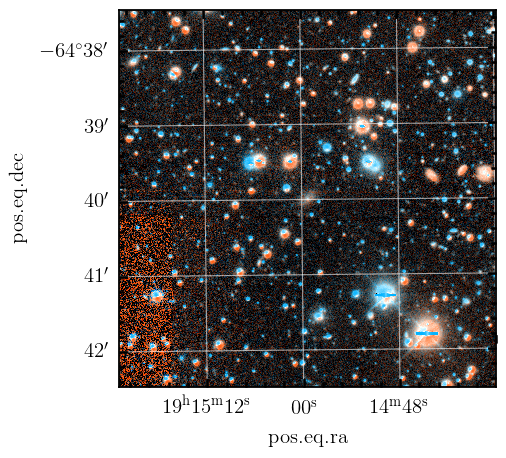

In [21]:
for obj in obj_cat:
    size = 120
    gi = []

    for filt in list('gi'):
        hdu = fits.open(f'./ELVES/for_jiaxuan/{obj["viz-id"]}-coadd_{filt}.fits')
        temp = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), 
                   obj['ra'], obj['dec'], size=(size, size), pixel_unit=False, pixel_scale=0.262)
        gi.append(temp[0].data)
        hdu.close()

    plt.imshow(lupton_rgb.make_lupton_rgb(1.1 * gi[0], 0.35 * (gi[0] + gi[1]), 0.5 * gi[1], 
                                          minimum=-0.1, stretch=0.7, Q=3,))

    plt.axis('off')
    plt.savefig(f'/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/{obj["viz-id"]}_{size}.png', 
                bbox_inches='tight')

## Finder charts

In [163]:
offsets = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/offset_stars.txt', 
    format='ascii')

In [164]:
import matplotlib.patches as patches

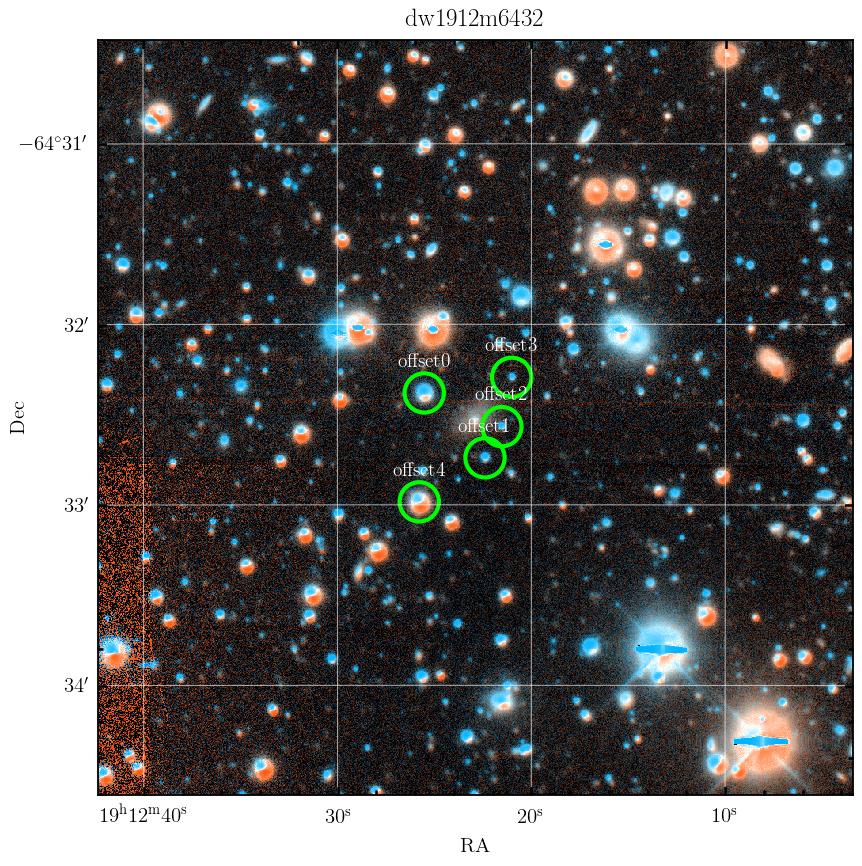

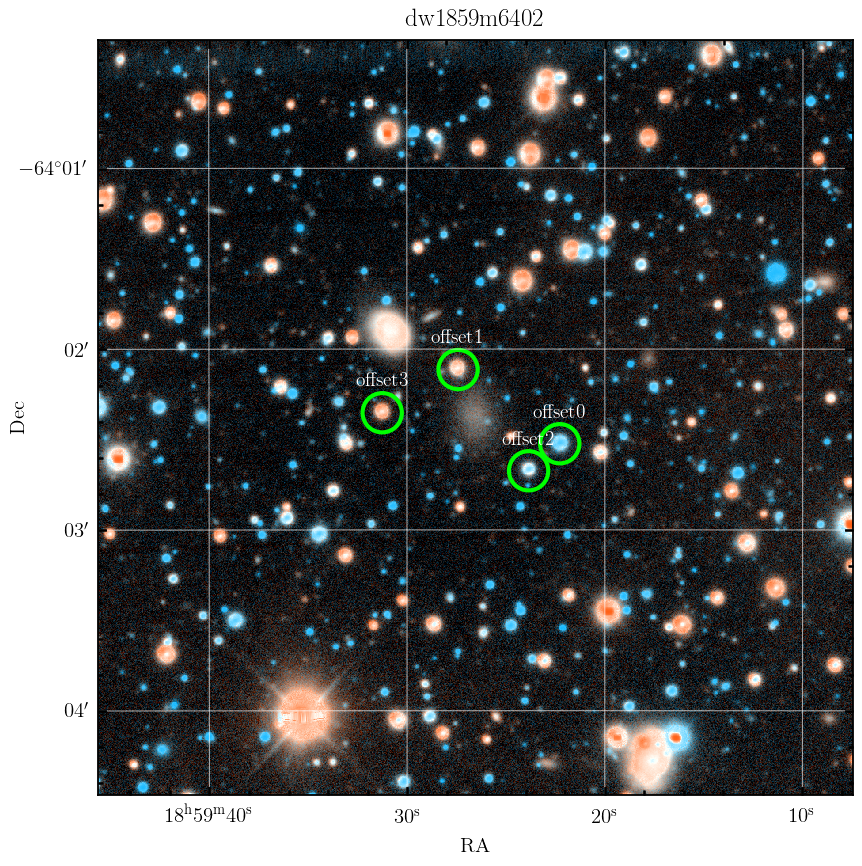

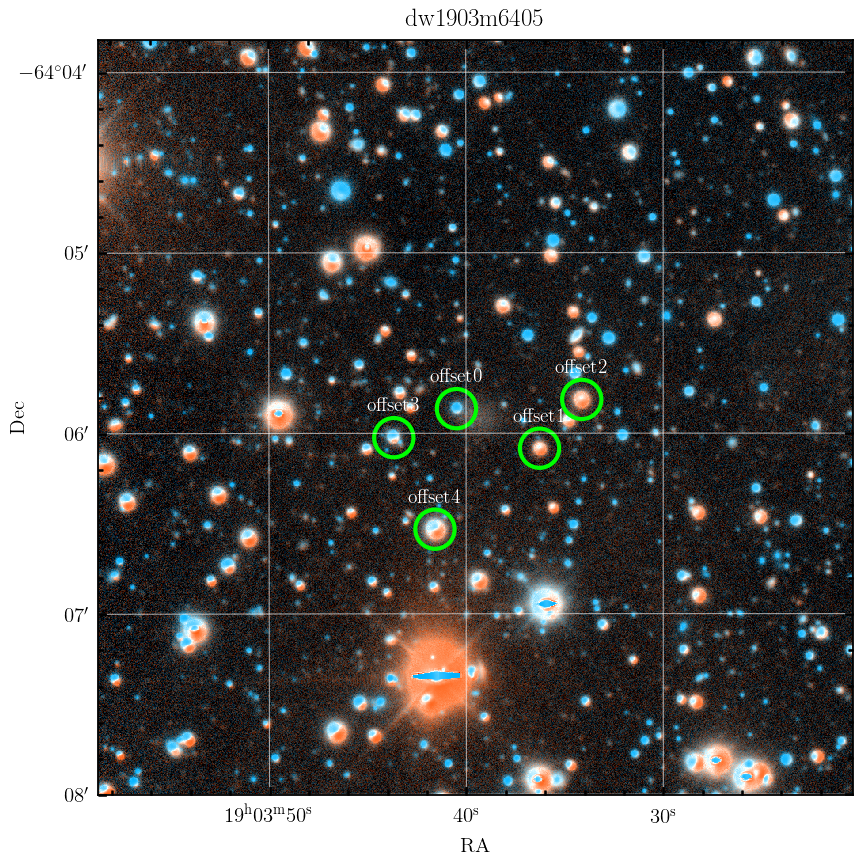

In [175]:
for obj in obj_cat[:]:
    size = 250
    gi = []

    for filt in list('gi'):
        hdu = fits.open(f'./ELVES/for_jiaxuan/{obj["viz-id"]}-coadd_{filt}.fits')
        w = wcs.WCS(hdu[0].header)
        temp = img_cutout(hdu[0].data, w, 
                   obj['ra'], obj['dec'], size=(size, size), pixel_unit=False, pixel_scale=0.262)
        gi.append(temp[0].data)
#         hdu.close()

    f = plt.figure(figsize=(10, 10))
    w = wcs.WCS(temp[2])
    ax = plt.subplot(projection=w)
    plt.imshow(lupton_rgb.make_lupton_rgb(1.1 * gi[0], 0.35 * (gi[0] + gi[1]), 0.5 * gi[1], 
                                          minimum=-0.1, stretch=0.7, Q=3,), origin='lower')
    
    # Create a Rectangle patch
    for star in offsets[[obj['viz-id'] in item for item in offsets['viz-id'].data]]:
        x, y = w.wcs_world2pix(star['ra'], star['dec'], 0)
#         rect = patches.Rectangle((800, 200), 50, 50, linewidth=4, 
#                                  edgecolor='g', facecolor='none',
#                                  transform=ax.get_transform('fk5'))
#         ax.add_patch(rect)
        ax.scatter(star['ra'], star['dec'], transform=ax.get_transform('fk5'), 
                   s=800, lw=3, edgecolor='lime', facecolor='none')
        ax.text(star['ra'], star['dec'] + 0.0024, star['viz-id'].lstrip(obj["viz-id"] + '-'), 
                ha='center', color='w',
                transform=ax.get_transform('fk5'), fontsize=14)
    
    plt.grid(color='white', ls='solid')
    plt.xlabel('RA')
    plt.ylabel('Dec', labelpad=0)
    plt.title(obj["viz-id"])
    plt.savefig(f'/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/{obj["viz-id"]}_finder.png', 
                bbox_inches='tight')
#     plt.close()

In [176]:
for obj in obj_cat:
    print(f'<img src="./catalogs/magellan_proposal/{obj["viz-id"]}_finder.png" width="600">')

<img src="./catalogs/magellan_proposal/dw1912m6432_finder.png" width="600">
<img src="./catalogs/magellan_proposal/dw1859m6402_finder.png" width="600">
<img src="./catalogs/magellan_proposal/dw1903m6405_finder.png" width="600">


### B&W

In [190]:
obscat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_July22_bright_large.txt', 
    format='ascii')
refstars = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/refstars.txt', 
    format='ascii')

In [191]:
for obj in obscat[1:-1]:
    _star = refstars[[obj['viz-id'] in name for name in refstars['viz-id']]]

    galaxy = SkyCoord(obj['ra'], obj['dec'], unit='deg')
    star = SkyCoord(_star['ra'], _star['dec'], unit='deg')
    
    dra, ddec = star.spherical_offsets_to(galaxy)
    print(obj['viz-id'], dra.to(u.arcsec), ddec.to(u.arcsec))

dw1859m6402 [-5.88283arcsec] [-15.7743arcsec]
dw1903m6405 [-6.45084arcsec] [-2.79201arcsec]
dw1912m6432 [-17.0188arcsec] [-7.95063arcsec]
40777 [3.3674arcsec] [-15.7684arcsec]
82230 [12.9767arcsec] [-1.98466arcsec]
79982 [40.4343arcsec] [-11.7434arcsec]
21534 [-27.1071arcsec] [-9.56663arcsec]
75212 [-45.1455arcsec] [-17.5423arcsec]
75570 [-19.5042arcsec] [-30.5982arcsec]
45406 [18.0866arcsec] [-19.2147arcsec]
86749 [-16.1316arcsec] [44.465arcsec]


dw1912m6432 -17.0188arcsec -7.95063arcsec
dw1859m6402 -5.88283arcsec -15.7743arcsec
dw1903m6405 -6.45084arcsec -2.79201arcsec


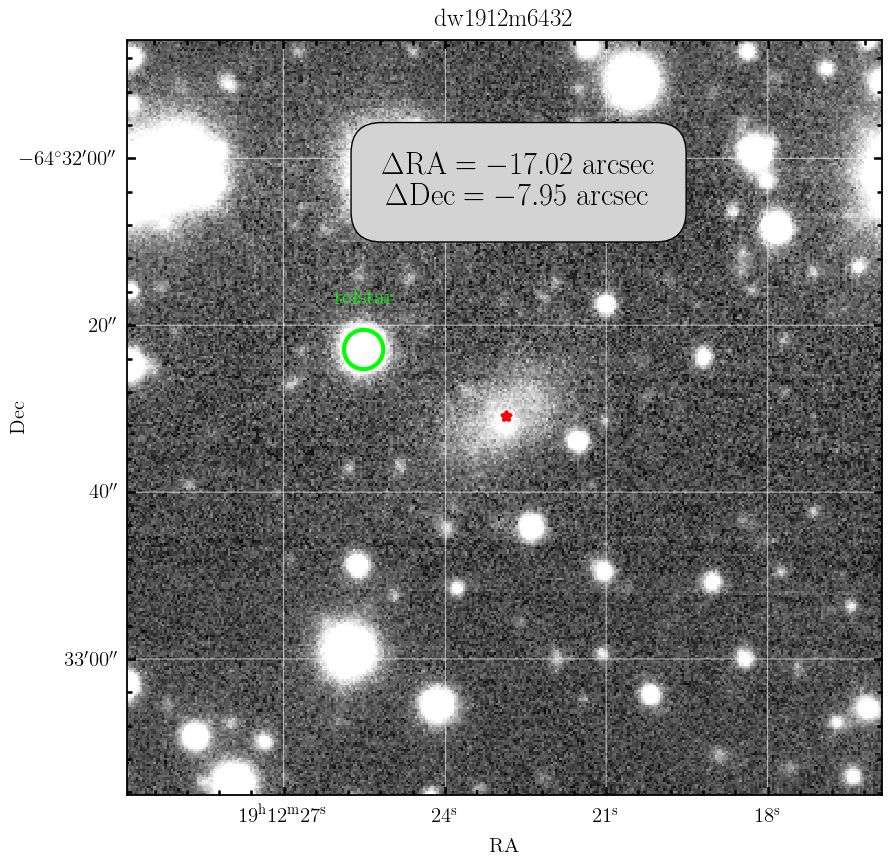

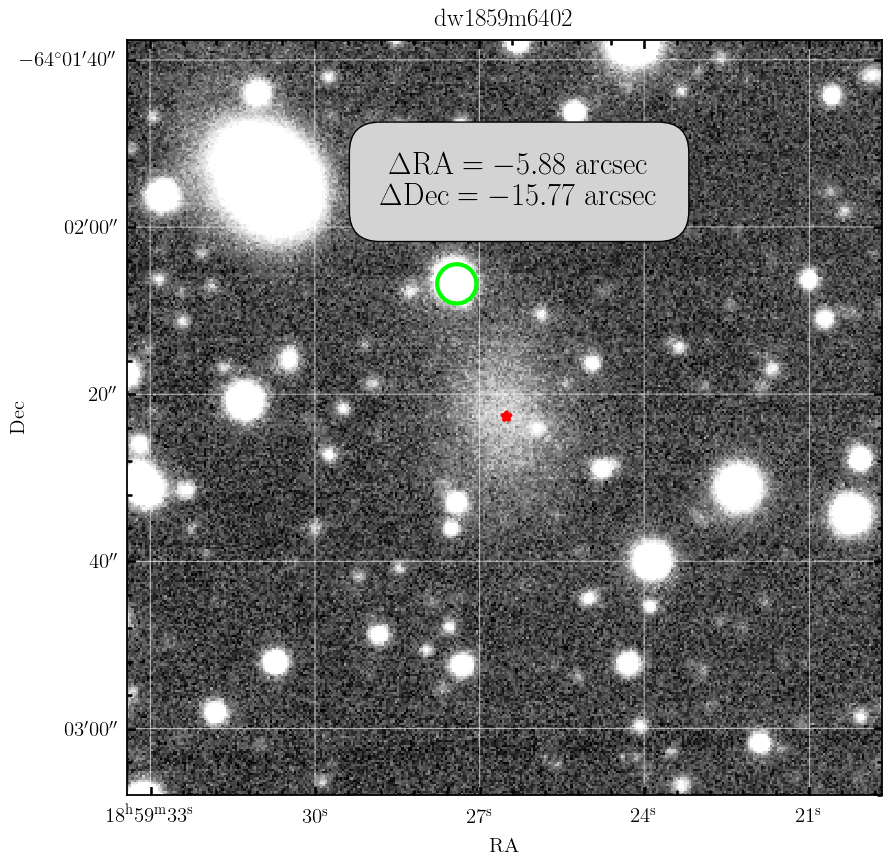

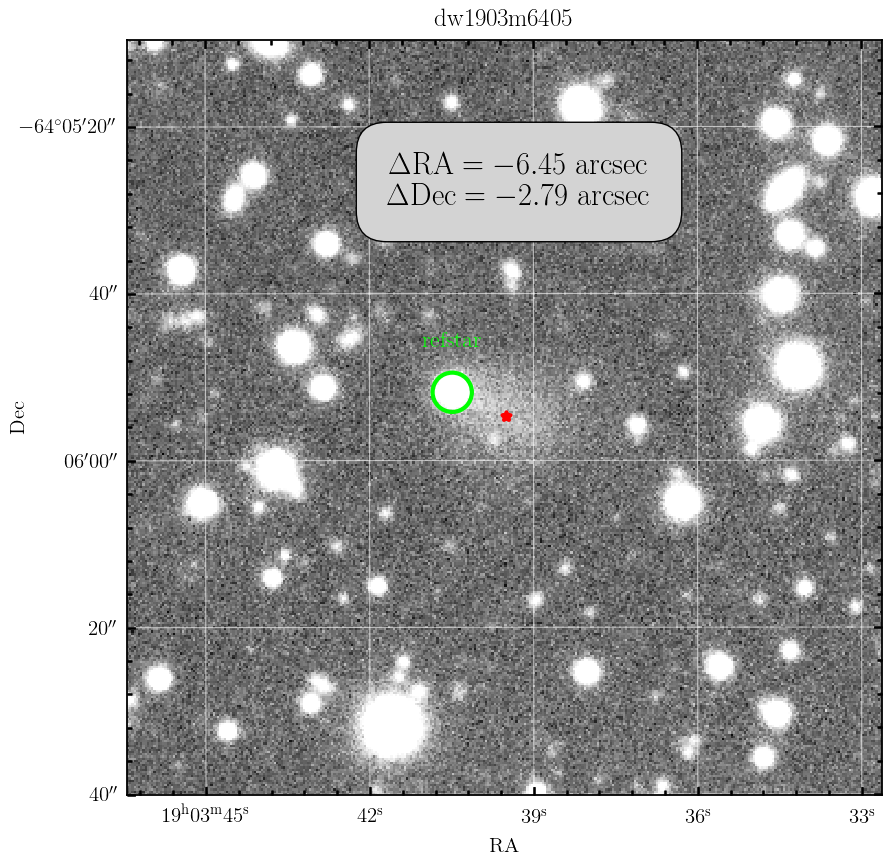

In [230]:
offsets = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/refstars.txt', 
    format='ascii')

for obj in obj_cat[:]:
    size = 90
    gi = []

    for filt in list('gi'):
        hdu = fits.open(f'./ELVES/for_jiaxuan/{obj["viz-id"]}-coadd_{filt}.fits')
        w = wcs.WCS(hdu[0].header)
        temp = img_cutout(hdu[0].data, w, 
                   obj['ra'], obj['dec'], size=(size, size), pixel_unit=False, pixel_scale=0.262)
        gi.append(temp[0].data)
#         hdu.close()

    f = plt.figure(figsize=(10, 10))
    w = wcs.WCS(temp[2])
    ax = plt.subplot(projection=w)
    try:
        ax = display_single(gi[1], cmap='Greys_r', ax=ax)
    except:
        pass
#     plt.imshow(, origin='lower')
    
    # show object
    ax.scatter(obj['ra'], obj['dec'], transform=ax.get_transform('fk5'), 
                   marker='*', lw=3, edgecolor='red', facecolor='red')
    
    for star in offsets[[obj['viz-id'] in item for item in offsets['viz-id'].data]]:
        
        gal_corr = SkyCoord(obj['ra'], obj['dec'], unit='deg')
        star_corr = SkyCoord(star['ra'], star['dec'], unit='deg')

        dra, ddec = star_corr.spherical_offsets_to(gal_corr)
        print(obj['viz-id'], dra.to(u.arcsec), ddec.to(u.arcsec))
    
        x, y = w.wcs_world2pix(star['ra'], star['dec'], 0)
#         rect = patches.Rectangle((800, 200), 50, 50, linewidth=4, 
#                                  edgecolor='g', facecolor='none',
#                                  transform=ax.get_transform('fk5'))
#         ax.add_patch(rect)
        ax.scatter(star['ra'], star['dec'], transform=ax.get_transform('fk5'), 
                   s=800, lw=3, edgecolor='lime', facecolor='none')
    
        ax.text(star['ra'], star['dec'] + 0.0015, star['viz-id'].lstrip(obj["viz-id"] + '-'), 
                ha='center', color='lime',
                transform=ax.get_transform('fk5'), fontsize=17)
        
        ax.text(obj['ra'] - 0.0010, obj['dec'] + 0.007, 
                r'$\Delta\mathrm{RA}=' + f'{dra.to(u.arcsec).value:.2f}' + r'\ \rm{arcsec}$' + '\n' + r'$\Delta\mathrm{Dec}=' + f'{ddec.to(u.arcsec).value:.2f}' + r'\ \rm{arcsec}$', 
                ha='center', color='k', fontweight='bold',
                transform=ax.get_transform('fk5'), fontsize=22,
                bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=1'))
        
    
    plt.grid(color='white', ls='solid')
    plt.xlabel('RA')
    plt.ylabel('Dec', labelpad=0)
    plt.title(obj["viz-id"])
    plt.savefig(f'/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/{obj["viz-id"]}_refstar_offset.png', 
                bbox_inches='tight')
#     plt.close()

In [233]:
for obj in obscat:
    print(f'<img src="./catalogs/magellan_proposal/{obj["viz-id"]}_refstar_offset.png" width="600">')

<img src="./catalogs/magellan_proposal/EG274_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/dw1859m6402_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/dw1903m6405_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/dw1912m6432_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/40777_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/82230_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/79982_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/21534_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/75212_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/75570_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/45406_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/86749_refstar_offset.png" width="600">
<img src="./catalogs/magellan_proposal/LTT1788